In [1]:
import sys
import torch  
import numpy as np  
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from torch.distributions.categorical import Categorical
import math
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from preprocess import mean, std, preprocess_input_function
from settings import train_batch_size, test_batch_size, train_push_batch_size
from settings import base_architecture, img_size, prototype_shape, num_classes, prototype_activation_function, add_on_layers_type
from receptive_field import compute_rf_prototype
import cv2
#from reward_model import construct_PrefNet, paired_cross_entropy_loss, PrefNet
from tqdm import tqdm
from settings import joint_optimizer_lrs, joint_lr_step_size
import skimage as sk
import skimage.io as skio
import train_and_test as tnt
from torch.utils.data import Subset
import time
import heapq
from resnet_features import resnet18_features, resnet34_features, resnet50_features, resnet101_features, resnet152_features
from densenet_features import densenet121_features, densenet161_features, densenet169_features, densenet201_features
from vgg_features import vgg11_features, vgg11_bn_features, vgg13_features, vgg13_bn_features, vgg16_features, vgg16_bn_features,\
                         vgg19_features, vgg19_bn_features

In [2]:
'''
Use PPnet's forward pass as the policy network (actor network); what about the network for value function (critic network)?
Since there are only determinant actions, this is essentially A2C...
'''
class A3C_PPnet(nn.Module):
    def __init__(self, PPnet, preference_model, k=1, p=5, learning_rate=1e-4, dummy_reward=False, train_batch_size=80):
        super(A3C_PPnet, self).__init__()
        
        
        self.PPnet = PPnet.cuda()
        self.k = k
        self.pf_model = preference_model.cuda()
        
        self.PPnet_multi = self.PPnet
        for p in self.PPnet_multi.module.features.parameters():
            p.requires_grad = False
        for p in self.PPnet_multi.module.add_on_layers.parameters():
            p.requires_grad = False
        self.PPnet_multi.module.prototype_vectors.requires_grad = True
        for p in self.PPnet_multi.module.last_layer.parameters():
            p.requires_grad = False
        
        self.train_batch_size = train_batch_size
        self.num_epoch = 0
        policy_optimizer_specs = [#{'params': self.PPnet.features.parameters(), 'lr': joint_optimizer_lrs['features'], 'weight_decay': 1e-3}, 
                                  #{'params': self.PPnet.add_on_layers.parameters(), 'lr': joint_optimizer_lrs['add_on_layers'], 'weight_decay': 1e-3},
                                  #{'params': self.PPnet.prototype_vectors, 'lr': joint_optimizer_lrs['prototype_vectors']},
                                  #{'params': self.PPnet.module.add_on_layers.parameters(), 'lr': 1e-4, 'weight_decay': 1e-5},
                                  {'params': self.PPnet.module.prototype_vectors, 'lr': 1e-3, 'weight_decay': 1e-4}
                                  ]
        self.policy_optimizer = torch.optim.Adam(policy_optimizer_specs)
        self.num_iteration = 0
        
        
    def get_heatmaps(self, batch_x, labels, pid):
        self.PPnet_multi.eval()
        n_prototypes = self.PPnet_multi.module.num_prototypes
        prototype_shape = self.PPnet_multi.module.prototype_shape
        max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]
        protoL_rf_info = self.PPnet_multi.module.proto_layer_rf_info
        
        batch_x = batch_x.cuda()
        protoL_input_torch, proto_dist_torch = self.PPnet_multi.module.push_forward(batch_x)
        
        proto_dist_ = proto_dist_torch.view(proto_dist_torch.shape[0], proto_dist_torch.shape[1], -1)
        # proto_dist_: (batch_size, 1000, 49)
        all_distances = torch.amin(proto_dist_, axis=-1)
        # all_distances: (batch_size, 1000)
        target_p = [pid]
        #for i in range(all_distances.shape[1]):
        #    class_i = torch.argmax(self.PPnet_multi.module.prototype_class_identity[i])
        #    if class_i == class_identity:
        #        target_p.append(i)
        
        proto_dist = torch.clone(proto_dist_torch)
       
        proto_dist = torch.transpose(proto_dist, 0, 1)
        dists = all_distances[:, target_p]
        dists = torch.transpose(dists, 0, 1)
        
    
        # proto_dist: (1000, batch_size)
        proto_dist_numpy = proto_dist.detach().cpu().numpy()
        
        
        original_imgs = []
        rescaled_patterns = []
        
        for j in target_p:
            
            original_imgs_j = []
            rescaled_patterns_j = []
           
            for i in range(len(batch_x)):
                closest_patch_indices_in_distance_map_j = list(np.unravel_index(np.argmin(proto_dist_numpy[j][i],axis=None), proto_dist_numpy[j][i].shape))
                closest_patch_indices_in_distance_map_j = [0] + closest_patch_indices_in_distance_map_j
                
                closest_patch_indices_in_img = compute_rf_prototype(batch_x.size(2), closest_patch_indices_in_distance_map_j, protoL_rf_info)
                closest_patch = \
                    batch_x[i, :, closest_patch_indices_in_img[1]:closest_patch_indices_in_img[2], closest_patch_indices_in_img[3]:closest_patch_indices_in_img[4]]
                closest_patch = closest_patch.cpu().numpy()
                closest_patch = np.transpose(closest_patch, (1, 2, 0))

                original_img = batch_x[i].cpu().numpy()
                original_img = np.transpose(original_img, (1, 2, 0))
                
                
                if self.PPnet_multi.module.prototype_activation_function == 'log':
                    act_pattern = np.log((proto_dist_numpy[j][i] + 1)/(proto_dist_numpy[j][i] + self.PPnet_multi.module.epsilon))
                elif self.PPnet_multi.module.prototype_activation_function == 'linear':
                    act_pattern = max_dist - proto_dist_numpy[j][i]
                else:
                    act_pattern = prototype_activation_function_in_numpy(proto_dist_numpy[j][i])

                patch_indices = closest_patch_indices_in_img[1:5]
                          
                upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
                rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
                rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
                
                original_img = original_img - np.amin(original_img)
                original_img = original_img / np.amax(original_img)
                original_imgs_j.append(original_img)
                rescaled_patterns_j.append(rescaled_act_pattern)
                
            
            original_imgs.append(original_imgs_j)
            rescaled_patterns.append(rescaled_patterns_j)
    
        return original_imgs, rescaled_patterns, dists
    
    '''
    imgs: (1000, 1, 224, 224, 3), patterns: (1000, 1, 224, 224)
    '''
    def get_rewards(self, imgs, patterns):
        
        num_p = len(imgs)
        assert num_p == len(patterns)
        batch_size = len(imgs[0])
        assert batch_size == len(patterns[0])
        
        with torch.no_grad():
            rewards = torch.empty((num_p, batch_size))
            for i in range(num_p):
                for j in range(batch_size):
                    img = np.array([imgs[i][j]])
                    img = np.transpose(img, (0, 3, 1, 2))
                    img = torch.from_numpy(img).cuda()
                
                    pattern = patterns[i][j]
                    pattern = np.array([pattern, pattern, pattern])
                    pattern = torch.from_numpy(np.array([pattern])).cuda()
                    reward = self.pf_model(img, pattern) 
                    rewards[i][j] = reward
                
        return rewards
        
    def joint_update(self, rewards, dists):
        #print(dists)
        
        assert rewards.shape[0] == len(dists)
        assert rewards.shape[1] == len(dists[0])
        
        self.policy_optimizer.zero_grad()
        loss = 0
        for i in range(rewards.shape[0]):
            for j in range(rewards.shape[1]):
                if dists[i][j] > 0:
                    loss -= (1 / (100*dists[i][j]+1)) * rewards[i][j]
                #elif dists[i][j] == 0:
                #    loss -= rewards[i][j]
        if loss != 0:
            loss.backward()
            self.policy_optimizer.step()
        return 
    
    
    def run(self, batch_x, labels, pid, update=True):

        original_imgs, rescaled_patterns, dists = self.get_heatmaps(batch_x, labels, pid)
        rewards = self.get_rewards(original_imgs, rescaled_patterns)
        if update:
            loss = self.joint_update(rewards, dists)
        
        
        
        return torch.mean(rewards)
   
    

In [3]:
def reselect_prototypes(a3c, update_threshold, select_threshold, bad_prototype_idx):
    # get the heatmaps by searching for the closest images in the entire dataset
    # can use different k values
    # heatmaps: (1000, 1, 224, 224, 3)
    # rewards: (1000,)
    # patch_ids: (1000, 3, (idx tuple))
    prototype_shape = a3c.PPnet_multi.module.prototype_shape
    
    initial_bad_rewards = []
    final_bad_rewards = []
    '''
    rewards = a3c.get_rewards(original_imgs, patterns)
    for i in range(len(rewards)):
        if rewards[i] < update_threshold:
            bad_prototype_idx.append(i)
            initial_bad_rewards.append(rewards[i])
    print("bad prototype number: ", len(bad_prototype_idx))
    print("initial mean bad reward: ", torch.mean(torch.tensor(initial_bad_rewards)))
    '''

    
    patch_ids = []
    failed_p = []
    #patch_ids = [patch_id[0] for patch_id in patch_ids]
    # patch_ids: (1000, tuple), where tuple := (img_idx, h, w)

    success_count = 0
    # loop over each prototype
    for k in tqdm(range(len(bad_prototype_idx))):
        j = bad_prototype_idx[k]
        a3c.PPnet_multi.eval()
        n_prototypes = a3c.PPnet_multi.module.num_prototypes
        prototype_shape = a3c.PPnet_multi.module.prototype_shape
        max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]
        protoL_rf_info = a3c.PPnet_multi.module.proto_layer_rf_info
        class_identity = torch.argmax(a3c.PPnet_multi.module.prototype_class_identity[j])
        class_idx = [x for x, y in enumerate(train_dataset.targets) if y == class_identity]
        class_start_idx = class_idx[0]
        class_dataset = Subset(train_dataset, class_idx)
        dataloader = torch.utils.data.DataLoader(class_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=False)
        batch_x, label = next(iter(dataloader))
        batch_x = batch_x.cuda()
        with torch.no_grad():
            initial_reward = a3c.run(batch_x, label, j, update=False)
        
        
        initial_bad_rewards.append(initial_reward.detach().cpu().numpy())
        # conv_outs: (80, 128, 7, 7)
        conv_outs = a3c.PPnet_multi.module.conv_features(batch_x)
        batch_idx = np.arange(batch_x.shape[0])
        class_idx_batch = batch_idx[label == class_identity]
        #print(class_idx_batch)
        class_outs = conv_outs[label == class_identity]
        if class_outs.shape[0] == 0:
            continue
        height = class_outs.shape[2]
        width = class_outs.shape[3]
        success = False
        for _ in range(200):
            img_idx = np.random.choice(class_outs.shape[0])
            h = np.random.choice(height)
            w = np.random.choice(width)
            
            patch_candidate = class_outs[img_idx, :, h:h+1, w:w+1]
            a3c.PPnet_multi.module.prototype_vectors.data[j] = patch_candidate
            #a3c.PPnet_multi.module.prototype_vectors.data.copy_(vec)
            # distances: (7, 7)
            with torch.no_grad():
                patch_reward = a3c.run(batch_x, label, j, update=False)
            '''
            distances = a3c.PPnet_multi.module._l2_convolution(class_outs[img_idx])[j].detach().cpu().numpy()

            if a3c.PPnet_multi.module.prototype_activation_function == 'log':
                act_pattern = np.log((distances + 1)/(distances + a3c.PPnet_multi.module.epsilon))
            elif a3c.PPnet_multi.module.prototype_activation_function == 'linear':
                act_pattern = max_dist - distances
            else:
                act_pattern = prototype_activation_function_in_numpy(distances)

            upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
            rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
            rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)

            img = torch.unsqueeze(batch_x[class_idx_batch[img_idx]], 0)
            pattern = torch.tensor(np.array([rescaled_act_pattern, rescaled_act_pattern, rescaled_act_pattern]))
            pattern = torch.unsqueeze(pattern, 0)

            patch_reward = a3c.pf_model(img, pattern.cuda()) 
            '''
            idx_tuple = (class_start_idx + img_idx, h, w)
            if patch_reward > select_threshold and idx_tuple not in patch_ids:
                patch_ids.append(idx_tuple)
                success = True
                success_count += 1
                break           
  
        if success:
            print("Prototype " + str(j) + " success!")
            final_bad_rewards.append(patch_reward.detach().cpu().numpy())
        else:
            print("Prototype " + str(j) + " failed!")
            failed_p.append(j)
    print("bad prototype number: ", len(bad_prototype_idx))
    if len(initial_bad_rewards) > 0:
        print("initial mean bad reward: ", np.mean(np.array(initial_bad_rewards)))
    if len(final_bad_rewards) > 0:
        print("final mean bad reward: ", np.mean(np.array(final_bad_rewards)))
    print("number of success: ", success_count)
    return final_bad_rewards, bad_prototype_idx, patch_ids, failed_p

In [4]:
base_architecture_to_features = {'resnet18': resnet18_features,
                                 'resnet34': resnet34_features,
                                 'resnet50': resnet50_features,
                                 'resnet101': resnet101_features,
                                 'resnet152': resnet152_features,
                                 'densenet121': densenet121_features,
                                 'densenet161': densenet161_features,
                                 'densenet169': densenet169_features,
                                 'densenet201': densenet201_features,
                                 'vgg11': vgg11_features,
                                 'vgg11_bn': vgg11_bn_features,
                                 'vgg13': vgg13_features,
                                 'vgg13_bn': vgg13_bn_features,
                                 'vgg16': vgg16_features,
                                 'vgg16_bn': vgg16_bn_features,
                                 'vgg19': vgg19_features,
                                 'vgg19_bn': vgg19_bn_features}


class PrefNet(nn.Module):

    def __init__(self, img_features, pattern_features, img_size, prototype_shape,
                 proto_layer_rf_info, num_classes, init_weights=False,
                 prototype_activation_function='log',
                 add_on_layers_type='bottleneck', 
                k = 1):

        super(PrefNet, self).__init__()
        self.img_size = img_size
        self.prototype_shape = prototype_shape
        self.num_prototypes = prototype_shape[0]
        self.num_classes = num_classes
        self.epsilon = 1e-4
        self.k = k
        
        # this has to be named features to allow the precise loading
        self.img_features = img_features
        self.pattern_features = pattern_features
        
        '''
        features_name = str(self.features).upper()
        if features_name.startswith('VGG') or features_name.startswith('RES'):
            first_add_on_layer_in_channels = \
                [i for i in features.modules() if isinstance(i, nn.Conv2d)][-1].out_channels
        elif features_name.startswith('DENSE'):
            first_add_on_layer_in_channels = \
                [i for i in features.modules() if isinstance(i, nn.BatchNorm2d)][-1].num_features
        else:
            raise Exception('other base base_architecture NOT implemented')
        '''
        
        '''    
        if add_on_layers_type == 'bottleneck':
            add_on_layers = []
            current_in_channels = first_add_on_layer_in_channels
            while (current_in_channels > self.prototype_shape[1]) or (len(add_on_layers) == 0):
                current_out_channels = max(self.prototype_shape[1], (current_in_channels // 2))
                add_on_layers.append(nn.Conv2d(in_channels=current_in_channels,
                                               out_channels=current_out_channels,
                                               kernel_size=1))
                add_on_layers.append(nn.ReLU())
                add_on_layers.append(nn.Conv2d(in_channels=current_out_channels,
                                               out_channels=current_out_channels,
                                               kernel_size=1))
                if current_out_channels > self.prototype_shape[1]:
                    add_on_layers.append(nn.ReLU())
                else:
                    assert(current_out_channels == self.prototype_shape[1])
                    add_on_layers.append(nn.Sigmoid())
                current_in_channels = current_in_channels // 2
            self.add_on_layers = nn.Sequential(*add_on_layers)
        else:
            self.add_on_layers = nn.Sequential(
                nn.Conv2d(in_channels=first_add_on_layer_in_channels, out_channels=self.prototype_shape[1], kernel_size=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=self.prototype_shape[1], out_channels=self.prototype_shape[1], kernel_size=1),
                nn.Sigmoid()
                )
        
        '''
                
#         self.prototype_vectors = nn.Parameter(torch.rand(self.prototype_shape),
#                                               requires_grad=True)

#         # do not make this just a tensor,
#         # since it will not be moved automatically to gpu
#         self.ones = nn.Parameter(torch.ones(self.prototype_shape),
#                                  requires_grad=False)

#         self.last_layer = nn.Linear(self.num_prototypes, self.num_classes,
#                                     bias=False) # do not use bias
    

        self.img_conv = nn.Sequential(
            nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3),
            nn.Sigmoid()
            )
        
        self.pattern_conv = nn.Sequential(
            nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3),
            nn.Sigmoid()
            )
        
        self.final_fc = nn.Sequential(
            # change here
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Sigmoid(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        
            )
        
        #self.fc1 = nn.Linear(6400, 512)
        #self.fc2 = nn.Linear(512, 32)
        #self.fc3 = nn.Linear(32, 1)
        #self.fc1 = nn.Linear(64, 16)
        

        if init_weights:
            self._initialize_weights()
            
            
    def conv_features(self, x):
        '''
        the feature input to prototype layer
        '''
        # Insert k and then img size
        x = self.features(x)
        #print("base features: ", x.shape)
        #x = self.add_on_layers(x)
        return x
    
    def forward(self, x, p):
        
        x = self.img_features(x)
        x = self.img_conv(x)
        
        p = self.pattern_features(p)
        p = self.pattern_conv(p)
        
        #out = torch.cat((x, p), dim=1)
        out = torch.flatten(p, 1) 
        out = self.final_fc(out)
        
        return out

    
    def _initialize_weights(self):
        for m in self.img_conv.modules():
            if isinstance(m, nn.Conv2d):
                # every init technique has an underscore _ in the name
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        for m in self.pattern_conv.modules():
            if isinstance(m, nn.Conv2d):
                # every init technique has an underscore _ in the name
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)




            
def construct_PrefNet(base_architecture, pretrained=True, img_size=224,
                    prototype_shape=(1000, 128, 1, 1), num_classes=200,
                    prototype_activation_function='log',
                    add_on_layers_type='bottleneck',
                    k = 1):
    img_features = base_architecture_to_features[base_architecture](pretrained=pretrained)
    pattern_features = base_architecture_to_features[base_architecture](pretrained=pretrained)
    layer_filter_sizes, layer_strides, layer_paddings = img_features.conv_info()
    proto_layer_rf_info = compute_proto_layer_rf_info_v2(img_size=img_size,
                                                         layer_filter_sizes=layer_filter_sizes,
                                                         layer_strides=layer_strides,
                                                         layer_paddings=layer_paddings,
                                                         prototype_kernel_size=prototype_shape[2])
    return PrefNet(img_features=img_features,
                   pattern_features=pattern_features,
                 img_size=img_size,
                 prototype_shape=prototype_shape,
                 proto_layer_rf_info=proto_layer_rf_info,
                 num_classes=num_classes,
                 init_weights=True,
                 prototype_activation_function=prototype_activation_function,
                 add_on_layers_type=add_on_layers_type,
                 k = k)


def paired_cross_entropy_loss(out1, out2, targets):
    
    total_loss = 0
    for i in range(len(targets)):
        
        if targets[i] == -1:
            p1 = torch.exp(out1[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - torch.log(p1)
        elif targets[i] == 1:
            p2 = torch.exp(out2[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - torch.log(p2)

        else:
            p1 = torch.exp(out1[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            p2 = torch.exp(out2[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - (0.5*torch.log(p1) + 0.5*torch.log(p2))
            
        total_loss += loss
    return total_loss



In [5]:
class ImagePatch:

    def __init__(self, patch, label, distance,
                 original_img=None, act_pattern=None, patch_indices=None, img_id=None):
        self.patch = patch
        self.label = label
        self.negative_distance = -distance

        self.original_img = original_img
        self.act_pattern = act_pattern
        self.patch_indices = patch_indices
        self.img_id = img_id

    def __lt__(self, other):
        return self.negative_distance < other.negative_distance


class ImagePatchInfo:

    def __init__(self, label, distance):
        self.label = label
        self.negative_distance = -distance

    def __lt__(self, other):
        return self.negative_distance < other.negative_distance

def find_k_nearest_patches_to_prototypes(dataloader, # pytorch dataloader (must be unnormalized in [0,1])
                                         prototype_network_parallel, # pytorch network with prototype_vectors
                                         k=1,
                                         batch_size = 80,
                                         preprocess_input_function=None, # normalize if needed
                                         full_save=False, # save all the images
                                         root_dir_for_saving_images=None,
                                         log=print,
                                         prototype_activation_function_in_numpy=None, heatmap_ratio = 1.0):
    prototype_network_parallel.eval()
    '''
    full_save=False will only return the class identity of the closest
    patches, but it will not save anything.
    '''
    log('find nearest patches')
    start = time.time()
    n_prototypes = prototype_network_parallel.module.num_prototypes
    
    prototype_shape = prototype_network_parallel.module.prototype_shape
    max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]

    protoL_rf_info = prototype_network_parallel.module.proto_layer_rf_info

    heaps = []
    # allocate an array of n_prototypes number of heaps
    for _ in range(n_prototypes):
        # a heap in python is just a maintained list
        heaps.append([])

    for idx, (search_batch_input, search_y) in tqdm(enumerate(dataloader)):
        #print('batch {}'.format(idx))
        if preprocess_input_function is not None:
            # print('preprocessing input for pushing ...')
            # search_batch = copy.deepcopy(search_batch_input)
            search_batch = preprocess_input_function(search_batch_input)

        else:
            search_batch = search_batch_input

        with torch.no_grad():
            search_batch = search_batch.cuda()
            protoL_input_torch, proto_dist_torch = \
                prototype_network_parallel.module.push_forward(search_batch)

        #protoL_input_ = np.copy(protoL_input_torch.detach().cpu().numpy())
        proto_dist_ = np.copy(proto_dist_torch.detach().cpu().numpy())
        
        # proto_dist_: (80, 1000, 7, 7)

        for img_idx, distance_map in enumerate(proto_dist_):
            for j in range(n_prototypes):
                # find the closest patches in this batch to prototype j

                closest_patch_distance_to_prototype_j = np.amin(distance_map[j])



                closest_patch_indices_in_distance_map_j = \
                    list(np.unravel_index(np.argmin(distance_map[j],axis=None),
                                          distance_map[j].shape))
                patch_idx = closest_patch_indices_in_distance_map_j
                
                closest_patch_indices_in_distance_map_j = [0] + closest_patch_indices_in_distance_map_j
                closest_patch_indices_in_img = \
                    compute_rf_prototype(search_batch.size(2),
                                         closest_patch_indices_in_distance_map_j,
                                         protoL_rf_info)
                closest_patch = \
                    search_batch_input[img_idx, :,
                                       closest_patch_indices_in_img[1]:closest_patch_indices_in_img[2],
                                       closest_patch_indices_in_img[3]:closest_patch_indices_in_img[4]]
                closest_patch = closest_patch.numpy()
                closest_patch = np.transpose(closest_patch, (1, 2, 0))

                original_img = search_batch_input[img_idx].numpy()
                original_img = np.transpose(original_img, (1, 2, 0))

                if prototype_network_parallel.module.prototype_activation_function == 'log':
                    act_pattern = np.log((distance_map[j] + 1)/(distance_map[j] + prototype_network_parallel.module.epsilon))
                elif prototype_network_parallel.module.prototype_activation_function == 'linear':
                    act_pattern = max_dist - distance_map[j]
                else:
                    act_pattern = prototype_activation_function_in_numpy(distance_map[j])

                # 4 numbers: height_start, height_end, width_start, width_end
                patch_indices = closest_patch_indices_in_img[1:5]

                # construct the closest patch object
                closest_patch = ImagePatch(patch=closest_patch,
                                           label=search_y[img_idx],
                                           distance=closest_patch_distance_to_prototype_j,
                                           original_img=original_img,
                                           act_pattern=act_pattern,
                                           patch_indices=patch_idx,
                                           img_id = idx * batch_size + img_idx)
                '''
                else:
                
                closest_patch = ImagePatchInfo(label=search_y[img_idx],
                                                   distance=closest_patch_distance_to_prototype_j)
                '''

                # add to the j-th heap 
                if len(heaps[j]) < k:
                    heapq.heappush(heaps[j], closest_patch)
                else:
                    # heappushpop runs more efficiently than heappush
                    # followed by heappop
                    heapq.heappushpop(heaps[j], closest_patch)
                    

    # after looping through the dataset every heap will
    # have the k closest prototypes
    original_imgs = []
    patterns = []
    patch_ids = []
    for j in range(n_prototypes):
        # finally sort the heap; the heap only contains the k closest
        # but they are not ranked yet
        heaps[j].sort()
        heaps[j] = heaps[j][::-1]

        original_imgs_j = []
        patterns_j = []
        patch_ids_j = []
        for i, patch in enumerate(heaps[j]):
            
            img_size = patch.original_img.shape[0]
            upsampled_act_pattern = cv2.resize(patch.act_pattern,
                                               dsize=(img_size, img_size),
                                               interpolation=cv2.INTER_CUBIC)
            rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
            rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
            
            # No need for these if using dummy reward model
            '''
            heatmap = cv2.applyColorMap(np.uint8(255*rescaled_act_pattern), cv2.COLORMAP_JET)
            heatmap = np.float32(heatmap) / 255
            heatmap = heatmap[...,::-1]

            overlayed_original_img = 0.5 * patch.original_img + heatmap_ratio * heatmap
            overlayed_original_img = overlayed_original_img - np.amin(overlayed_original_img)
            overlayed_original_img = overlayed_original_img / np.amax(overlayed_original_img)
            '''
            original_imgs_j.append(patch.original_img)
            patterns_j.append(rescaled_act_pattern)
            patch_ids_j.append((patch.img_id, patch.patch_indices[0], patch.patch_indices[1]))
        original_imgs.append(original_imgs_j)
        patterns.append(patterns_j)
        patch_ids.append(patch_ids_j)
    end = time.time()
    log('\tfind nearest patches time: \t{0}'.format(end - start))

    return original_imgs, patterns, patch_ids

In [6]:
#ppnet = torch.load(r'/scratch/users/jiaxun1218//saved_models/densenet121/r1_160.7568.pth')
ppnet = torch.load(r'./R1_cars/007_vgg19_5/150.8162.pth')
#ppnet = torch.load(r'./ppnet_results/005_resnet34/350.7749.pth')
ppnet = torch.nn.DataParallel(ppnet)
#pf_model = construct_PrefNet("resnet18")
#pf_model.load_state_dict(torch.load("./human_comparisons/pref_model_009_65+35_ep50_adam_0.0001"))
#pf_model = torch.load(r'./human_comparisons/pref_model_009_65+35_ep50_adam_0.0001_1')
pf_model = torch.load('./human_comparisons/reward_model_cars_0.870.pth')

In [7]:
train_push_dir = './stanford_cars/car_data/car_data/train'
test_dir = './stanford_cars/car_data/car_data/test'
train_dir = './stanford_cars/car_data/car_data/train_augmented'
num_classes = 196
img_size = 224
normalize = transforms.Normalize(mean=mean, std=std)

train_dataset = datasets.ImageFolder(
        train_push_dir,
        transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=80, shuffle=False,
    num_workers=2, pin_memory=False)

test_dataset = datasets.ImageFolder(
        test_dir,
        transforms.Compose([
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]))
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False,
    num_workers=2, pin_memory=False)

aug_train_dataset = datasets.ImageFolder(
        train_dir,
        transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ]))

aug_train_loader = torch.utils.data.DataLoader(
    aug_train_dataset, batch_size=80, shuffle=False,
    num_workers=2, pin_memory=False)

In [7]:
indices = []

'''
Each batch of size 80 consists of 16 shuffled blocks
'''
#for i in range(200):
#    class_i = [ind for ind, ele in enumerate(train_dataset.targets) if ele == i]
#    indices.append(class_i[:10])
#    indices.append(class_i[10:20])
#    indices.append(class_i[20:])
    
    #indices.append(class_i[:5])
    #indices.append(class_i[5:10])
    #indices.append(class_i[10:15])
    #indices.append(class_i[15:20])
    #indices.append(class_i[20:25])
    #indices.append(class_i[25:])

class_p_idx = 4
class_i = [ele for ind, ele in enumerate(train_dataset.targets) if ind == 5163][0]
class_0 = [ind for ind, ele in enumerate(train_dataset.targets) if ele == class_i]
print(class_i)
print(class_0)

123
[5138, 5139, 5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149, 5150, 5151, 5152, 5153, 5154, 5155, 5156, 5157, 5158, 5159, 5160, 5161, 5162, 5163, 5164, 5165, 5166, 5167, 5168, 5169, 5170, 5171, 5172, 5173, 5174, 5175, 5176, 5177, 5178, 5179, 5180, 5181]


In [8]:
a3c = A3C_PPnet(ppnet, pf_model)

In [10]:
# patch_ids: (1000, 1, 1, 3)
#original_imgs, patterns, patch_ids = find_k_nearest_patches_to_prototypes(train_loader, a3c.PPnet_multi, k=1, batch_size = 80, preprocess_input_function=None, full_save=False, root_dir_for_saving_images=None, log=print, prototype_activation_function_in_numpy=None, heatmap_ratio = 1.0)
patch_ids = np.array(patch_ids).reshape(196, 5, 3)

In [11]:
np.save('./R2_cars/007_vgg19_5/patch_ids.npy', patch_ids)

In [12]:
patch_ids[0]

array([[35,  1,  4],
       [32,  5,  2],
       [ 4,  2,  1],
       [ 1,  5,  5],
       [44,  4,  1]])

In [13]:
'''
Update each prototype
'''
def joint_update(a3c, p_indices, reselect_threshold, update_threshold, select_threshold, patch_ids):
    #original_imgs, patterns, patch_ids = find_k_nearest_patches_to_prototypes(train_loader, a3c.PPnet_multi, k=1)
    #final_bad_rewards, bad_prototype_idx, patch_ids = reselect_prototypes(a3c, update_threshold, select_threshold)
    #print("Reselction result (mean): ", np.mean(final_bad_rewards))
    
    # patch_ids: np.array (200, 5, 3)
    bad_prototype_idx = []
    num_reweighed = 0
    for p_idx in tqdm(p_indices):
        
        
        start = time.time()
        old_vec = torch.clone(a3c.PPnet_multi.module.prototype_vectors.data)
        
        class_idx = p_idx // 5
        if p_idx % 5 == 0:
            class_idx = p_idx // 5
            class_imgs = [x for x, y in enumerate(train_dataset.targets) if y == class_idx]
            class_dataset = Subset(train_dataset, class_imgs)
            dataloader = torch.utils.data.DataLoader(class_dataset, batch_size=32, shuffle=False, num_workers=1, pin_memory=False)
            batch, label = next(iter(dataloader))
        best_vec = torch.clone(a3c.PPnet_multi.module.prototype_vectors.data[p_idx])
        best_iter = 0
        best_reward = a3c.run(batch, label, p_idx)
        initial_reward = best_reward
        #print(initial_reward)
        class_p_idx = p_idx % 5
        # for k in range(class_p_idx):
        #     if np.array_equal(patch_ids[class_idx][class_p_idx], patch_ids[class_idx][k]):
        #         print(class_idx, class_p_idx)
        #         num_duplicate += 1
        #         for i in range(len(old_vec)):
        #             a3c.PPnet_multi.module.prototype_vectors.data[i] = old_vec[i]
        #         continue
        if initial_reward > update_threshold:
            for i in range(len(old_vec)):
                a3c.PPnet_multi.module.prototype_vectors.data[i] = old_vec[i]
            continue
        if initial_reward < reselect_threshold:
            bad_prototype_idx.append(p_idx)
            for i in range(len(old_vec)):
                a3c.PPnet_multi.module.prototype_vectors.data[i] = old_vec[i]
            continue
        
        # Reward reweighing
        print("Prototype: " + str(p_idx) + " initial reward: " + str(initial_reward))
        convergence_counter = 0
        for i in range(200):
            avg_reward = a3c.run(batch, label, p_idx)
            if avg_reward > best_reward:
                convergence_counter = 0
                best_vec = torch.clone(a3c.PPnet_multi.module.prototype_vectors.data[p_idx])
                best_iter = i
                best_reward = avg_reward
            convergence_counter += 1
            if convergence_counter > 20:
                break

        a3c.PPnet_multi.module.prototype_vectors.data[p_idx] = best_vec
        num_reweighed += 1
        end = time.time()
        print("Prototype: " + str(p_idx) + " best reward: " + str(best_reward) + " iter: " + str(best_iter) + " time: " + str(end - start))
        for i in range(len(old_vec)):
            if i != p_idx:
                a3c.PPnet_multi.module.prototype_vectors.data[i] = old_vec[i]
        
    #print("Number of high-reward duplicates: ", num_duplicate)   
    print("Number of bad prototypes: ", len(bad_prototype_idx))
    print("Number of reweighed prototypes: ", num_reweighed)
    final_bad_rewards, bad_prototype_idx, patch_ids, failed_p = reselect_prototypes(a3c, reselect_threshold, select_threshold, bad_prototype_idx)
    return bad_prototype_idx, patch_ids, failed_p

In [14]:
#patch_ids = np.load('./R2_cars/004_densenet121/patch_ids.npy')
bad_prototype_idx, patch_ids, failed_p = joint_update(a3c, np.arange(980), 0.50, 0.90, 0.90, patch_ids)

  2%|▏         | 16/980 [00:09<10:31,  1.53it/s]

Prototype: 16 initial reward: tensor(0.8977)


  2%|▏         | 17/980 [00:18<49:33,  3.09s/it]

Prototype: 16 best reward: tensor(0.8977) iter: 0 time: 8.72731351852417


  2%|▏         | 19/980 [00:18<27:32,  1.72s/it]

Prototype: 19 initial reward: tensor(0.8934)


  2%|▏         | 20/980 [00:37<1:46:14,  6.64s/it]

Prototype: 19 best reward: tensor(0.8970) iter: 24 time: 18.091394662857056
Prototype: 20 initial reward: tensor(0.8958)


  2%|▏         | 21/980 [00:46<2:00:10,  7.52s/it]

Prototype: 20 best reward: tensor(0.9037) iter: 1 time: 9.553603649139404
Prototype: 21 initial reward: tensor(0.8984)


  2%|▏         | 22/980 [01:08<3:07:02, 11.71s/it]

Prototype: 21 best reward: tensor(0.9676) iter: 33 time: 21.483007192611694
Prototype: 22 initial reward: tensor(0.8967)


  2%|▏         | 23/980 [01:20<3:08:54, 11.84s/it]

Prototype: 22 best reward: tensor(0.9003) iter: 9 time: 12.130136013031006


  5%|▍         | 48/980 [01:33<07:59,  1.95it/s]  

Prototype: 48 initial reward: tensor(0.5122)


  5%|▌         | 49/980 [02:02<2:22:05,  9.16s/it]

Prototype: 48 best reward: tensor(0.7109) iter: 53 time: 29.31103801727295


  6%|▌         | 57/980 [02:06<15:46,  1.03s/it]  

Prototype: 57 initial reward: tensor(0.8598)


  6%|▌         | 58/980 [02:28<1:51:55,  7.28s/it]

Prototype: 57 best reward: tensor(0.9272) iter: 34 time: 21.87036418914795


  7%|▋         | 65/980 [02:32<15:19,  1.01s/it]  

Prototype: 65 initial reward: tensor(0.8849)


  7%|▋         | 66/980 [02:48<1:25:13,  5.59s/it]

Prototype: 65 best reward: tensor(0.9135) iter: 18 time: 16.287320613861084
Prototype: 66 initial reward: tensor(0.8840)


  7%|▋         | 67/980 [03:14<2:57:39, 11.67s/it]

Prototype: 66 best reward: tensor(0.9135) iter: 44 time: 25.84691548347473


  7%|▋         | 72/980 [03:16<36:25,  2.41s/it]  

Prototype: 72 initial reward: tensor(0.5424)


  7%|▋         | 73/980 [03:25<1:04:43,  4.28s/it]

Prototype: 72 best reward: tensor(0.5424) iter: 0 time: 8.64119029045105


  8%|▊         | 81/980 [03:29<12:50,  1.17it/s]  

Prototype: 81 initial reward: tensor(0.7276)


  8%|▊         | 82/980 [03:47<1:28:03,  5.88s/it]

Prototype: 81 best reward: tensor(0.8131) iter: 23 time: 17.59763789176941
Prototype: 82 initial reward: tensor(0.8651)


  8%|▊         | 83/980 [03:58<1:49:15,  7.31s/it]

Prototype: 82 best reward: tensor(0.8712) iter: 5 time: 10.616461038589478


  9%|▊         | 85/980 [03:58<56:29,  3.79s/it]  

Prototype: 85 initial reward: tensor(0.6984)


  9%|▉         | 86/980 [04:15<1:51:45,  7.50s/it]

Prototype: 85 best reward: tensor(0.7994) iter: 17 time: 16.150492191314697


  9%|▉         | 87/980 [04:15<1:19:58,  5.37s/it]

Prototype: 87 initial reward: tensor(0.8092)


  9%|▉         | 88/980 [04:24<1:34:32,  6.36s/it]

Prototype: 87 best reward: tensor(0.8137) iter: 0 time: 8.64593505859375


  9%|▉         | 90/980 [04:25<49:17,  3.32s/it]  

Prototype: 90 initial reward: tensor(0.8856)


  9%|▉         | 91/980 [04:34<1:14:52,  5.05s/it]

Prototype: 90 best reward: tensor(0.8856) iter: 0 time: 9.075350284576416


  9%|▉         | 92/980 [04:34<54:08,  3.66s/it]  

Prototype: 92 initial reward: tensor(0.8817)


  9%|▉         | 93/980 [04:53<2:03:03,  8.32s/it]

Prototype: 92 best reward: tensor(0.8832) iter: 27 time: 19.195947885513306


 10%|▉         | 94/980 [04:54<1:27:50,  5.95s/it]

Prototype: 94 initial reward: tensor(0.6844)


 10%|▉         | 95/980 [05:02<1:39:40,  6.76s/it]

Prototype: 94 best reward: tensor(0.6844) iter: 0 time: 8.629646062850952
Prototype: 95 initial reward: tensor(0.8886)


 10%|▉         | 96/980 [05:12<1:51:52,  7.59s/it]

Prototype: 95 best reward: tensor(0.8906) iter: 1 time: 9.528748989105225


 10%|▉         | 97/980 [05:12<1:20:01,  5.44s/it]

Prototype: 97 initial reward: tensor(0.7677)


 10%|█         | 98/980 [05:23<1:41:14,  6.89s/it]

Prototype: 97 best reward: tensor(0.8967) iter: 4 time: 10.253289937973022
Prototype: 98 initial reward: tensor(0.8858)


 10%|█         | 99/980 [05:40<2:28:29, 10.11s/it]

Prototype: 98 best reward: tensor(0.8945) iter: 23 time: 17.625766038894653
Prototype: 99 initial reward: tensor(0.7649)


 10%|█         | 100/980 [05:49<2:21:53,  9.67s/it]

Prototype: 99 best reward: tensor(0.7649) iter: 0 time: 8.636222124099731


 12%|█▏        | 118/980 [05:59<07:38,  1.88it/s]  

Prototype: 118 initial reward: tensor(0.8808)


 12%|█▏        | 119/980 [06:17<1:26:09,  6.00s/it]

Prototype: 118 best reward: tensor(0.8951) iter: 26 time: 18.756868839263916


 13%|█▎        | 125/980 [06:20<15:44,  1.10s/it]  

Prototype: 125 initial reward: tensor(0.5927)


 13%|█▎        | 126/980 [06:30<50:19,  3.54s/it]

Prototype: 125 best reward: tensor(0.5927) iter: 0 time: 9.193922996520996


 13%|█▎        | 130/980 [06:31<16:23,  1.16s/it]

Prototype: 130 initial reward: tensor(0.8251)


 13%|█▎        | 131/980 [06:45<1:08:45,  4.86s/it]

Prototype: 130 best reward: tensor(0.8862) iter: 11 time: 13.483887672424316
Prototype: 131 initial reward: tensor(0.8313)


 13%|█▎        | 132/980 [06:53<1:24:46,  6.00s/it]

Prototype: 131 best reward: tensor(0.8313) iter: 0 time: 8.638101577758789


 14%|█▍        | 137/980 [06:56<20:55,  1.49s/it]  

Prototype: 137 initial reward: tensor(0.7424)


 14%|█▍        | 138/980 [07:10<1:12:25,  5.16s/it]

Prototype: 137 best reward: tensor(0.7576) iter: 13 time: 13.712966918945312
Prototype: 138 initial reward: tensor(0.6296)


 14%|█▍        | 139/980 [07:18<1:26:54,  6.20s/it]

Prototype: 138 best reward: tensor(0.6296) iter: 0 time: 8.611345052719116
Prototype: 139 initial reward: tensor(0.6284)


 14%|█▍        | 140/980 [07:29<1:45:17,  7.52s/it]

Prototype: 139 best reward: tensor(0.6388) iter: 5 time: 10.586410999298096


 15%|█▌        | 151/980 [07:35<10:01,  1.38it/s]  

Prototype: 151 initial reward: tensor(0.5259)


 16%|█▌        | 152/980 [07:56<1:31:32,  6.63s/it]

Prototype: 151 best reward: tensor(0.5404) iter: 30 time: 20.403977394104004


 16%|█▌        | 153/980 [07:56<1:05:41,  4.77s/it]

Prototype: 153 initial reward: tensor(0.5331)


 16%|█▌        | 154/980 [08:05<1:21:34,  5.93s/it]

Prototype: 153 best reward: tensor(0.5331) iter: 0 time: 8.61583161354065


 17%|█▋        | 163/980 [08:10<09:59,  1.36it/s]  

Prototype: 163 initial reward: tensor(0.8867)


 17%|█▋        | 164/980 [08:26<1:14:38,  5.49s/it]

Prototype: 163 best reward: tensor(0.8959) iter: 20 time: 16.566120147705078


 17%|█▋        | 171/980 [08:31<14:18,  1.06s/it]  

Prototype: 171 initial reward: tensor(0.8541)


 18%|█▊        | 172/980 [08:40<45:14,  3.36s/it]

Prototype: 171 best reward: tensor(0.8541) iter: 0 time: 8.708717823028564
Prototype: 172 initial reward: tensor(0.8526)


 18%|█▊        | 173/980 [08:48<1:06:44,  4.96s/it]

Prototype: 172 best reward: tensor(0.8526) iter: 0 time: 8.68582820892334


 18%|█▊        | 174/980 [08:49<48:18,  3.60s/it]  

Prototype: 174 initial reward: tensor(0.8937)


 18%|█▊        | 175/980 [08:57<1:08:32,  5.11s/it]

Prototype: 174 best reward: tensor(0.8937) iter: 0 time: 8.623123168945312


 19%|█▊        | 182/980 [09:01<12:17,  1.08it/s]  

Prototype: 182 initial reward: tensor(0.5174)


 19%|█▊        | 183/980 [09:10<43:08,  3.25s/it]

Prototype: 182 best reward: tensor(0.5174) iter: 0 time: 8.655666589736938


 19%|█▉        | 184/980 [09:10<31:46,  2.40s/it]

Prototype: 184 initial reward: tensor(0.8853)


 19%|█▉        | 185/980 [09:20<59:40,  4.50s/it]

Prototype: 184 best reward: tensor(0.9053) iter: 2 time: 9.409150838851929


 20%|█▉        | 195/980 [09:25<07:34,  1.73it/s]

Prototype: 195 initial reward: tensor(0.8833)


 20%|██        | 196/980 [09:47<1:32:21,  7.07s/it]

Prototype: 195 best reward: tensor(0.9164) iter: 33 time: 22.1942355632782


 21%|██        | 202/980 [09:50<17:19,  1.34s/it]  

Prototype: 202 initial reward: tensor(0.7958)


 21%|██        | 203/980 [09:59<45:43,  3.53s/it]

Prototype: 202 best reward: tensor(0.7958) iter: 0 time: 8.63662600517273


 22%|██▏       | 212/980 [10:04<08:23,  1.53it/s]

Prototype: 212 initial reward: tensor(0.6048)


 22%|██▏       | 213/980 [10:24<1:22:53,  6.48s/it]

Prototype: 212 best reward: tensor(0.6779) iter: 29 time: 20.07310390472412
Prototype: 213 initial reward: tensor(0.5733)


 22%|██▏       | 214/980 [10:37<1:48:58,  8.54s/it]

Prototype: 213 best reward: tensor(0.5803) iter: 12 time: 13.307563304901123


 22%|██▏       | 220/980 [10:40<17:51,  1.41s/it]  

Prototype: 220 initial reward: tensor(0.8140)


 23%|██▎       | 221/980 [11:04<1:42:43,  8.12s/it]

Prototype: 220 best reward: tensor(0.8530) iter: 37 time: 23.765087127685547
Prototype: 221 initial reward: tensor(0.8656)


 23%|██▎       | 222/980 [11:18<2:05:24,  9.93s/it]

Prototype: 221 best reward: tensor(0.8828) iter: 14 time: 14.127644777297974
Prototype: 222 initial reward: tensor(0.5093)


 23%|██▎       | 223/980 [11:29<2:09:29, 10.26s/it]

Prototype: 222 best reward: tensor(0.5358) iter: 6 time: 11.033822059631348


 23%|██▎       | 224/980 [11:30<1:32:04,  7.31s/it]

Prototype: 224 initial reward: tensor(0.8365)


 23%|██▎       | 225/980 [11:40<1:42:58,  8.18s/it]

Prototype: 224 best reward: tensor(0.8710) iter: 4 time: 10.213619232177734


 23%|██▎       | 230/980 [11:43<22:04,  1.77s/it]  

Prototype: 230 initial reward: tensor(0.8487)


 24%|██▎       | 231/980 [11:52<50:43,  4.06s/it]

Prototype: 230 best reward: tensor(0.8487) iter: 0 time: 9.409778833389282


 24%|██▎       | 232/980 [11:52<36:59,  2.97s/it]

Prototype: 232 initial reward: tensor(0.7888)


 24%|██▍       | 233/980 [12:01<58:12,  4.67s/it]

Prototype: 232 best reward: tensor(0.7888) iter: 0 time: 8.645061492919922


 24%|██▍       | 234/980 [12:01<42:11,  3.39s/it]

Prototype: 234 initial reward: tensor(0.8699)


 24%|██▍       | 235/980 [12:18<1:29:32,  7.21s/it]

Prototype: 234 best reward: tensor(0.8746) iter: 19 time: 16.10603904724121


 24%|██▍       | 238/980 [12:19<34:44,  2.81s/it]  

Prototype: 238 initial reward: tensor(0.8937)


 24%|██▍       | 239/980 [12:35<1:22:29,  6.68s/it]

Prototype: 238 best reward: tensor(0.9303) iter: 18 time: 15.694876670837402


 25%|██▍       | 244/980 [12:37<18:33,  1.51s/it]  

Prototype: 244 initial reward: tensor(0.8710)


 25%|██▌       | 245/980 [12:46<44:59,  3.67s/it]

Prototype: 244 best reward: tensor(0.8710) iter: 0 time: 8.696125507354736


 26%|██▌       | 255/980 [12:51<06:30,  1.86it/s]

Prototype: 255 initial reward: tensor(0.7428)


 26%|██▌       | 256/980 [13:28<2:18:26, 11.47s/it]

Prototype: 255 best reward: tensor(0.9728) iter: 71 time: 36.97462272644043


 27%|██▋       | 265/980 [13:32<10:35,  1.13it/s]  

Prototype: 265 initial reward: tensor(0.8817)


 27%|██▋       | 266/980 [13:42<41:23,  3.48s/it]

Prototype: 265 best reward: tensor(0.8870) iter: 1 time: 9.505488634109497


 29%|██▉       | 286/980 [13:53<08:00,  1.44it/s]

Prototype: 286 initial reward: tensor(0.8863)


 29%|██▉       | 287/980 [14:02<35:33,  3.08s/it]

Prototype: 286 best reward: tensor(0.8863) iter: 0 time: 8.62927794456482


 29%|██▉       | 288/980 [14:02<26:15,  2.28s/it]

Prototype: 288 initial reward: tensor(0.8855)


 29%|██▉       | 289/980 [14:18<1:11:21,  6.20s/it]

Prototype: 288 best reward: tensor(0.9685) iter: 17 time: 15.325403690338135


 30%|██▉       | 290/980 [14:18<51:19,  4.46s/it]  

Prototype: 290 initial reward: tensor(0.8235)


 30%|██▉       | 291/980 [14:27<1:08:28,  5.96s/it]

Prototype: 290 best reward: tensor(0.8235) iter: 0 time: 9.448652505874634


 31%|███       | 301/980 [14:32<08:01,  1.41it/s]  

Prototype: 301 initial reward: tensor(0.8568)


 31%|███       | 302/980 [14:41<34:50,  3.08s/it]

Prototype: 301 best reward: tensor(0.8568) iter: 0 time: 8.611038208007812
Prototype: 302 initial reward: tensor(0.8862)


 31%|███       | 303/980 [15:05<1:44:08,  9.23s/it]

Prototype: 302 best reward: tensor(0.9707) iter: 38 time: 23.557349681854248
Prototype: 303 initial reward: tensor(0.8902)


 31%|███       | 304/980 [15:15<1:48:30,  9.63s/it]

Prototype: 303 best reward: tensor(0.9072) iter: 5 time: 10.551276206970215


 32%|███▏      | 312/980 [15:20<13:15,  1.19s/it]  

Prototype: 312 initial reward: tensor(0.8435)


 32%|███▏      | 313/980 [15:30<43:15,  3.89s/it]

Prototype: 312 best reward: tensor(0.8648) iter: 4 time: 10.17814326286316


 33%|███▎      | 319/980 [15:33<09:49,  1.12it/s]

Prototype: 319 initial reward: tensor(0.8228)


 33%|███▎      | 320/980 [15:43<39:05,  3.55s/it]

Prototype: 319 best reward: tensor(0.8288) iter: 3 time: 9.751147985458374


 34%|███▍      | 333/980 [15:50<05:40,  1.90it/s]

Prototype: 333 initial reward: tensor(0.8606)


 34%|███▍      | 334/980 [15:59<31:46,  2.95s/it]

Prototype: 333 best reward: tensor(0.8695) iter: 0 time: 8.595787286758423


 35%|███▌      | 347/980 [16:06<06:21,  1.66it/s]

Prototype: 347 initial reward: tensor(0.8678)


 36%|███▌      | 348/980 [16:14<31:43,  3.01s/it]

Prototype: 347 best reward: tensor(0.8678) iter: 0 time: 8.61612844467163


 37%|███▋      | 360/980 [16:21<05:40,  1.82it/s]

Prototype: 360 initial reward: tensor(0.8845)


 37%|███▋      | 361/980 [16:30<32:17,  3.13s/it]

Prototype: 360 best reward: tensor(0.8845) iter: 0 time: 9.136946678161621


 38%|███▊      | 370/980 [16:34<05:36,  1.81it/s]

Prototype: 370 initial reward: tensor(0.7482)


 38%|███▊      | 371/980 [16:49<47:45,  4.71s/it]

Prototype: 370 best reward: tensor(0.9026) iter: 12 time: 14.383075475692749


 39%|███▊      | 378/980 [16:52<09:06,  1.10it/s]

Prototype: 378 initial reward: tensor(0.8857)


 39%|███▊      | 379/980 [17:01<32:16,  3.22s/it]

Prototype: 378 best reward: tensor(0.8857) iter: 0 time: 8.60785698890686


 39%|███▉      | 381/980 [17:02<19:12,  1.92s/it]

Prototype: 381 initial reward: tensor(0.8658)


 39%|███▉      | 382/980 [17:11<39:29,  3.96s/it]

Prototype: 381 best reward: tensor(0.9038) iter: 0 time: 8.70092225074768


 41%|████      | 400/980 [17:20<04:28,  2.16it/s]

Prototype: 400 initial reward: tensor(0.6944)


 41%|████      | 401/980 [17:33<40:19,  4.18s/it]

Prototype: 400 best reward: tensor(0.7187) iter: 9 time: 12.829957246780396


 41%|████      | 403/980 [17:34<21:40,  2.25s/it]

Prototype: 403 initial reward: tensor(0.8829)


 41%|████      | 404/980 [17:48<54:43,  5.70s/it]

Prototype: 403 best reward: tensor(0.9643) iter: 13 time: 13.728528261184692


 42%|████▏     | 412/980 [17:52<07:46,  1.22it/s]

Prototype: 412 initial reward: tensor(0.8814)


 42%|████▏     | 413/980 [18:11<58:42,  6.21s/it]

Prototype: 412 best reward: tensor(0.8815) iter: 26 time: 18.77557063102722
Prototype: 413 initial reward: tensor(0.8291)


 42%|████▏     | 414/980 [18:21<1:12:04,  7.64s/it]

Prototype: 413 best reward: tensor(0.8975) iter: 6 time: 10.959886312484741


 43%|████▎     | 420/980 [18:24<12:01,  1.29s/it]  

Prototype: 420 initial reward: tensor(0.8706)


 43%|████▎     | 421/980 [18:34<34:09,  3.67s/it]

Prototype: 420 best reward: tensor(0.8706) iter: 0 time: 9.202109336853027


 43%|████▎     | 423/980 [18:34<18:35,  2.00s/it]

Prototype: 423 initial reward: tensor(0.8499)


 43%|████▎     | 424/980 [18:48<51:15,  5.53s/it]

Prototype: 423 best reward: tensor(0.9106) iter: 13 time: 13.752850770950317


 44%|████▍     | 431/980 [18:52<09:46,  1.07s/it]

Prototype: 431 initial reward: tensor(0.8864)


 44%|████▍     | 432/980 [19:03<35:52,  3.93s/it]

Prototype: 431 best reward: tensor(0.9361) iter: 5 time: 10.58086371421814
Prototype: 432 initial reward: tensor(0.8950)


 44%|████▍     | 433/980 [19:13<52:57,  5.81s/it]

Prototype: 432 best reward: tensor(0.9237) iter: 4 time: 10.18501329421997


 44%|████▍     | 435/980 [19:14<27:43,  3.05s/it]

Prototype: 435 initial reward: tensor(0.8929)


 44%|████▍     | 436/980 [19:33<1:09:57,  7.72s/it]

Prototype: 435 best reward: tensor(0.9310) iter: 23 time: 18.582563161849976


 45%|████▍     | 439/980 [19:34<26:16,  2.91s/it]  

Prototype: 439 initial reward: tensor(0.8719)


 45%|████▍     | 440/980 [19:49<1:00:44,  6.75s/it]

Prototype: 439 best reward: tensor(0.8766) iter: 18 time: 15.680297374725342


 46%|████▌     | 453/980 [19:56<04:56,  1.78it/s]  

Prototype: 453 initial reward: tensor(0.8040)


 46%|████▋     | 454/980 [20:06<30:22,  3.46s/it]

Prototype: 453 best reward: tensor(0.8765) iter: 4 time: 10.220107555389404


 46%|████▋     | 455/980 [20:07<22:17,  2.55s/it]

Prototype: 455 initial reward: tensor(0.7868)


 47%|████▋     | 456/980 [20:16<39:56,  4.57s/it]

Prototype: 455 best reward: tensor(0.7868) iter: 0 time: 9.282536506652832


 47%|████▋     | 460/980 [20:18<12:14,  1.41s/it]

Prototype: 460 initial reward: tensor(0.7809)


 47%|████▋     | 461/980 [20:27<33:25,  3.86s/it]

Prototype: 460 best reward: tensor(0.7809) iter: 0 time: 9.57165265083313
Prototype: 461 initial reward: tensor(0.7608)


 47%|████▋     | 462/980 [20:36<45:47,  5.30s/it]

Prototype: 461 best reward: tensor(0.7753) iter: 0 time: 8.647535562515259
Prototype: 462 initial reward: tensor(0.8939)


 47%|████▋     | 463/980 [20:49<1:05:29,  7.60s/it]

Prototype: 462 best reward: tensor(0.9297) iter: 11 time: 12.941435813903809


 47%|████▋     | 465/980 [20:50<33:44,  3.93s/it]  

Prototype: 465 initial reward: tensor(0.7463)


 48%|████▊     | 466/980 [21:02<54:52,  6.41s/it]

Prototype: 465 best reward: tensor(0.8045) iter: 8 time: 12.165870428085327


 48%|████▊     | 471/980 [21:05<13:24,  1.58s/it]

Prototype: 471 initial reward: tensor(0.8988)


 48%|████▊     | 472/980 [21:23<57:06,  6.75s/it]

Prototype: 471 best reward: tensor(0.9167) iter: 26 time: 18.783162355422974


 48%|████▊     | 474/980 [21:24<29:36,  3.51s/it]

Prototype: 474 initial reward: tensor(0.8997)


 48%|████▊     | 475/980 [21:33<42:41,  5.07s/it]

Prototype: 474 best reward: tensor(0.8997) iter: 0 time: 8.69709038734436


 49%|████▉     | 478/980 [21:35<17:28,  2.09s/it]

Prototype: 478 initial reward: tensor(0.8427)


 49%|████▉     | 479/980 [21:50<51:27,  6.16s/it]

Prototype: 478 best reward: tensor(0.8550) iter: 18 time: 15.6553635597229


 49%|████▉     | 481/980 [21:52<27:55,  3.36s/it]

Prototype: 481 initial reward: tensor(0.8643)


 49%|████▉     | 482/980 [22:02<44:52,  5.41s/it]

Prototype: 481 best reward: tensor(0.9040) iter: 4 time: 10.17200779914856


 49%|████▉     | 485/980 [22:03<17:32,  2.13s/it]

Prototype: 485 initial reward: tensor(0.8217)


 50%|████▉     | 486/980 [22:22<58:20,  7.09s/it]

Prototype: 485 best reward: tensor(0.8496) iter: 23 time: 18.648260593414307


 51%|█████     | 501/980 [22:29<05:17,  1.51it/s]

Prototype: 501 initial reward: tensor(0.6398)


 51%|█████     | 502/980 [22:38<25:13,  3.17s/it]

Prototype: 501 best reward: tensor(0.6455) iter: 1 time: 8.99170732498169


 52%|█████▏    | 507/980 [22:41<07:44,  1.02it/s]

Prototype: 507 initial reward: tensor(0.8766)


 52%|█████▏    | 508/980 [23:01<53:22,  6.79s/it]

Prototype: 507 best reward: tensor(0.9671) iter: 30 time: 20.31288743019104


 53%|█████▎    | 517/980 [23:06<06:18,  1.22it/s]

Prototype: 517 initial reward: tensor(0.7850)


 53%|█████▎    | 518/980 [23:24<46:44,  6.07s/it]

Prototype: 517 best reward: tensor(0.8596) iter: 25 time: 18.311050176620483


 53%|█████▎    | 519/980 [23:25<33:35,  4.37s/it]

Prototype: 519 initial reward: tensor(0.8500)


 53%|█████▎    | 520/980 [23:44<1:08:24,  8.92s/it]

Prototype: 519 best reward: tensor(0.8571) iter: 28 time: 19.531302213668823
Prototype: 520 initial reward: tensor(0.8946)


 53%|█████▎    | 521/980 [23:54<1:09:16,  9.06s/it]

Prototype: 520 best reward: tensor(0.8946) iter: 0 time: 9.346403121948242


 54%|█████▍    | 534/980 [24:00<04:20,  1.71it/s]  

Prototype: 534 initial reward: tensor(0.8959)


 55%|█████▍    | 535/980 [24:09<22:13,  3.00s/it]

Prototype: 534 best reward: tensor(0.9093) iter: 0 time: 8.615636587142944


 55%|█████▌    | 543/980 [24:13<04:42,  1.55it/s]

Prototype: 543 initial reward: tensor(0.7553)


 56%|█████▌    | 544/980 [24:39<58:57,  8.11s/it]

Prototype: 543 best reward: tensor(0.9289) iter: 43 time: 25.520639419555664


 56%|█████▌    | 545/980 [24:39<42:03,  5.80s/it]

Prototype: 545 initial reward: tensor(0.6199)


 56%|█████▌    | 546/980 [25:01<1:17:15, 10.68s/it]

Prototype: 545 best reward: tensor(0.9235) iter: 33 time: 22.048511505126953


 56%|█████▌    | 549/980 [25:02<28:13,  3.93s/it]  

Prototype: 549 initial reward: tensor(0.8283)


 56%|█████▌    | 550/980 [25:32<1:24:40, 11.81s/it]

Prototype: 549 best reward: tensor(0.9194) iter: 55 time: 30.193809032440186


 56%|█████▋    | 553/980 [25:34<31:18,  4.40s/it]  

Prototype: 553 initial reward: tensor(0.8919)


 57%|█████▋    | 554/980 [25:54<1:03:40,  8.97s/it]

Prototype: 553 best reward: tensor(0.9094) iter: 28 time: 19.6084246635437


 59%|█████▉    | 581/980 [26:09<03:58,  1.67it/s]  

Prototype: 581 initial reward: tensor(0.8171)


 59%|█████▉    | 582/980 [26:23<31:38,  4.77s/it]

Prototype: 581 best reward: tensor(0.8765) iter: 15 time: 14.488702297210693


 61%|██████    | 599/980 [26:32<03:11,  1.98it/s]

Prototype: 599 initial reward: tensor(0.8858)


 61%|██████    | 600/980 [26:46<29:45,  4.70s/it]

Prototype: 599 best reward: tensor(0.9139) iter: 15 time: 14.473205327987671


 61%|██████▏   | 602/980 [26:48<16:27,  2.61s/it]

Prototype: 602 initial reward: tensor(0.8814)


 62%|██████▏   | 603/980 [26:56<27:46,  4.42s/it]

Prototype: 602 best reward: tensor(0.8814) iter: 0 time: 8.622284412384033
Prototype: 603 initial reward: tensor(0.8006)


 62%|██████▏   | 604/980 [27:07<39:21,  6.28s/it]

Prototype: 603 best reward: tensor(0.8335) iter: 5 time: 10.602893590927124


 62%|██████▏   | 605/980 [27:07<28:14,  4.52s/it]

Prototype: 605 initial reward: tensor(0.8176)


 62%|██████▏   | 606/980 [27:23<49:30,  7.94s/it]

Prototype: 605 best reward: tensor(0.8218) iter: 17 time: 15.909910917282104


 64%|██████▍   | 627/980 [27:34<03:05,  1.91it/s]

Prototype: 627 initial reward: tensor(0.8687)


 64%|██████▍   | 628/980 [27:43<18:41,  3.19s/it]

Prototype: 627 best reward: tensor(0.8772) iter: 2 time: 9.382165908813477


 64%|██████▍   | 632/980 [27:45<06:44,  1.16s/it]

Prototype: 632 initial reward: tensor(0.8948)


 65%|██████▍   | 633/980 [27:54<19:45,  3.42s/it]

Prototype: 632 best reward: tensor(0.8948) iter: 0 time: 8.654888391494751


 66%|██████▌   | 643/980 [27:59<03:17,  1.71it/s]

Prototype: 643 initial reward: tensor(0.8875)


 66%|██████▌   | 644/980 [28:22<39:47,  7.11s/it]

Prototype: 643 best reward: tensor(0.9710) iter: 35 time: 22.301523208618164


 66%|██████▌   | 646/980 [28:23<20:55,  3.76s/it]

Prototype: 646 initial reward: tensor(0.8610)


 66%|██████▌   | 647/980 [28:36<36:12,  6.52s/it]

Prototype: 646 best reward: tensor(0.8909) iter: 22 time: 12.965723752975464
Prototype: 647 initial reward: tensor(0.8824)


 66%|██████▌   | 648/980 [28:43<37:29,  6.78s/it]

Prototype: 647 best reward: tensor(0.8968) iter: 3 time: 7.348912000656128


 66%|██████▌   | 649/980 [28:43<26:40,  4.84s/it]

Prototype: 649 initial reward: tensor(0.5123)


 66%|██████▋   | 650/980 [28:56<38:59,  7.09s/it]

Prototype: 649 best reward: tensor(0.5146) iter: 20 time: 12.334909677505493


 67%|██████▋   | 652/980 [28:57<21:19,  3.90s/it]

Prototype: 652 initial reward: tensor(0.8929)


 67%|██████▋   | 653/980 [29:10<35:22,  6.49s/it]

Prototype: 652 best reward: tensor(0.9111) iter: 10 time: 12.521631479263306


 67%|██████▋   | 654/980 [29:10<25:21,  4.67s/it]

Prototype: 654 initial reward: tensor(0.5608)


 67%|██████▋   | 655/980 [29:26<42:28,  7.84s/it]

Prototype: 654 best reward: tensor(0.5609) iter: 17 time: 15.240907192230225


 67%|██████▋   | 658/980 [29:27<16:14,  3.03s/it]

Prototype: 658 initial reward: tensor(0.8780)


 67%|██████▋   | 659/980 [29:36<25:49,  4.83s/it]

Prototype: 658 best reward: tensor(0.8816) iter: 1 time: 9.007356405258179
Prototype: 659 initial reward: tensor(0.8986)


 67%|██████▋   | 660/980 [29:54<46:14,  8.67s/it]

Prototype: 659 best reward: tensor(0.9178) iter: 23 time: 17.62918758392334


 69%|██████▉   | 675/980 [30:02<02:29,  2.04it/s]

Prototype: 675 initial reward: tensor(0.8824)


 69%|██████▉   | 676/980 [30:25<37:15,  7.35s/it]

Prototype: 675 best reward: tensor(0.9749) iter: 36 time: 23.346532344818115


 69%|██████▉   | 678/980 [30:26<19:10,  3.81s/it]

Prototype: 678 initial reward: tensor(0.8186)


 69%|██████▉   | 679/980 [30:39<33:36,  6.70s/it]

Prototype: 678 best reward: tensor(0.9043) iter: 12 time: 13.427736282348633


 69%|██████▉   | 681/980 [30:41<18:12,  3.65s/it]

Prototype: 681 initial reward: tensor(0.8086)


 70%|██████▉   | 682/980 [30:54<32:36,  6.57s/it]

Prototype: 681 best reward: tensor(0.9680) iter: 12 time: 13.34010124206543


 70%|██████▉   | 685/980 [30:55<12:22,  2.52s/it]

Prototype: 685 initial reward: tensor(0.6510)


 70%|███████   | 686/980 [31:26<53:01, 10.82s/it]

Prototype: 685 best reward: tensor(0.9751) iter: 53 time: 30.180248737335205
Prototype: 686 initial reward: tensor(0.8326)


 70%|███████   | 687/980 [31:45<1:05:14, 13.36s/it]

Prototype: 686 best reward: tensor(0.9108) iter: 27 time: 19.27018094062805


 71%|███████   | 693/980 [31:48<09:41,  2.03s/it]  

Prototype: 693 initial reward: tensor(0.8913)


 71%|███████   | 694/980 [31:57<19:40,  4.13s/it]

Prototype: 693 best reward: tensor(0.9061) iter: 1 time: 9.019675970077515


 71%|███████   | 696/980 [31:59<11:37,  2.46s/it]

Prototype: 696 initial reward: tensor(0.6991)


 71%|███████   | 697/980 [32:07<20:18,  4.31s/it]

Prototype: 696 best reward: tensor(0.6991) iter: 0 time: 8.606591939926147


 71%|███████▏  | 700/980 [32:08<08:08,  1.75s/it]

Prototype: 700 initial reward: tensor(0.8547)


 72%|███████▏  | 701/980 [32:22<24:21,  5.24s/it]

Prototype: 700 best reward: tensor(0.8620) iter: 11 time: 13.37337875366211


 72%|███████▏  | 707/980 [32:25<04:54,  1.08s/it]

Prototype: 707 initial reward: tensor(0.8076)


 72%|███████▏  | 708/980 [32:39<23:14,  5.13s/it]

Prototype: 707 best reward: tensor(0.8654) iter: 15 time: 14.556301593780518


 72%|███████▏  | 710/980 [32:40<12:14,  2.72s/it]

Prototype: 710 initial reward: tensor(0.8342)


 73%|███████▎  | 711/980 [32:50<22:22,  4.99s/it]

Prototype: 710 best reward: tensor(0.8823) iter: 3 time: 10.27725076675415


 73%|███████▎  | 720/980 [32:55<02:49,  1.53it/s]

Prototype: 720 initial reward: tensor(0.8786)


 74%|███████▎  | 721/980 [33:19<32:46,  7.59s/it]

Prototype: 720 best reward: tensor(0.9581) iter: 34 time: 23.776927947998047


 74%|███████▍  | 724/980 [33:20<12:14,  2.87s/it]

Prototype: 724 initial reward: tensor(0.8850)


 74%|███████▍  | 725/980 [33:29<20:33,  4.84s/it]

Prototype: 724 best reward: tensor(0.8913) iter: 2 time: 9.413574457168579


 74%|███████▍  | 726/980 [33:30<15:40,  3.70s/it]

Prototype: 726 initial reward: tensor(0.8988)


 74%|███████▍  | 727/980 [33:40<22:52,  5.43s/it]

Prototype: 726 best reward: tensor(0.9337) iter: 2 time: 9.425583124160767


 75%|███████▍  | 731/980 [33:43<07:58,  1.92s/it]

Prototype: 731 initial reward: tensor(0.8571)


 75%|███████▍  | 732/980 [33:55<21:38,  5.24s/it]

Prototype: 731 best reward: tensor(0.8769) iter: 11 time: 12.9583899974823


 75%|███████▍  | 734/980 [33:56<11:22,  2.77s/it]

Prototype: 734 initial reward: tensor(0.8073)


 75%|███████▌  | 735/980 [34:05<18:29,  4.53s/it]

Prototype: 734 best reward: tensor(0.8073) iter: 0 time: 8.614922523498535


 75%|███████▌  | 737/980 [34:07<10:56,  2.70s/it]

Prototype: 737 initial reward: tensor(0.8424)


 75%|███████▌  | 738/980 [34:16<18:03,  4.48s/it]

Prototype: 737 best reward: tensor(0.8449) iter: 0 time: 8.611760377883911


 75%|███████▌  | 739/980 [34:16<13:04,  3.26s/it]

Prototype: 739 initial reward: tensor(0.8299)


 76%|███████▌  | 740/980 [34:25<19:30,  4.88s/it]

Prototype: 739 best reward: tensor(0.8299) iter: 0 time: 8.637212753295898


 77%|███████▋  | 752/980 [34:32<02:21,  1.61it/s]

Prototype: 752 initial reward: tensor(0.7548)


 77%|███████▋  | 753/980 [34:50<22:39,  5.99s/it]

Prototype: 752 best reward: tensor(0.8351) iter: 25 time: 18.493987560272217


 78%|███████▊  | 763/980 [34:55<02:26,  1.48it/s]

Prototype: 763 initial reward: tensor(0.7560)


 78%|███████▊  | 764/980 [35:07<14:08,  3.93s/it]

Prototype: 763 best reward: tensor(0.9738) iter: 7 time: 11.507208585739136


 80%|███████▉  | 781/980 [35:16<01:59,  1.67it/s]

Prototype: 781 initial reward: tensor(0.8036)


 80%|███████▉  | 782/980 [35:27<12:41,  3.84s/it]

Prototype: 781 best reward: tensor(0.8192) iter: 7 time: 11.395669937133789


 80%|████████  | 784/980 [35:28<06:50,  2.09s/it]

Prototype: 784 initial reward: tensor(0.7597)


 80%|████████  | 785/980 [35:48<23:33,  7.25s/it]

Prototype: 784 best reward: tensor(0.9558) iter: 27 time: 19.256802320480347


 80%|████████  | 786/980 [35:48<17:09,  5.31s/it]

Prototype: 786 initial reward: tensor(0.5539)


 80%|████████  | 787/980 [35:59<21:53,  6.80s/it]

Prototype: 786 best reward: tensor(0.5863) iter: 7 time: 10.284003973007202


 80%|████████  | 788/980 [35:59<15:35,  4.87s/it]

Prototype: 788 initial reward: tensor(0.8511)


 81%|████████  | 789/980 [36:14<25:26,  7.99s/it]

Prototype: 788 best reward: tensor(0.8884) iter: 21 time: 15.257310628890991
Prototype: 789 initial reward: tensor(0.8521)


 81%|████████  | 790/980 [36:24<26:47,  8.46s/it]

Prototype: 789 best reward: tensor(0.8813) iter: 5 time: 9.540220737457275


 81%|████████  | 791/980 [36:25<19:29,  6.19s/it]

Prototype: 791 initial reward: tensor(0.8525)


 81%|████████  | 792/980 [36:34<22:48,  7.28s/it]

Prototype: 791 best reward: tensor(0.8888) iter: 3 time: 9.80843997001648


 83%|████████▎ | 810/980 [36:44<01:19,  2.15it/s]

Prototype: 810 initial reward: tensor(0.8003)


 83%|████████▎ | 811/980 [36:54<09:34,  3.40s/it]

Prototype: 810 best reward: tensor(0.8096) iter: 1 time: 10.222528457641602
Prototype: 811 initial reward: tensor(0.5936)


 83%|████████▎ | 812/980 [37:03<14:13,  5.08s/it]

Prototype: 811 best reward: tensor(0.6062) iter: 1 time: 8.98534083366394


 84%|████████▍ | 821/980 [37:08<02:10,  1.22it/s]

Prototype: 821 initial reward: tensor(0.8635)


 84%|████████▍ | 822/980 [37:34<22:17,  8.47s/it]

Prototype: 821 best reward: tensor(0.9143) iter: 45 time: 26.299968719482422
Prototype: 822 initial reward: tensor(0.8145)


 84%|████████▍ | 823/980 [37:47<25:23,  9.70s/it]

Prototype: 822 best reward: tensor(0.9145) iter: 10 time: 12.577625036239624
Prototype: 823 initial reward: tensor(0.8300)


 84%|████████▍ | 824/980 [37:55<24:24,  9.39s/it]

Prototype: 823 best reward: tensor(0.8300) iter: 0 time: 8.643496036529541
Prototype: 824 initial reward: tensor(0.8696)


 84%|████████▍ | 825/980 [38:12<29:44, 11.51s/it]

Prototype: 824 best reward: tensor(0.9070) iter: 20 time: 16.44876718521118


 84%|████████▍ | 826/980 [38:13<21:27,  8.36s/it]

Prototype: 826 initial reward: tensor(0.7797)


 84%|████████▍ | 827/980 [38:31<28:58, 11.36s/it]

Prototype: 826 best reward: tensor(0.7930) iter: 25 time: 18.341946840286255
Prototype: 827 initial reward: tensor(0.7805)


 84%|████████▍ | 828/980 [38:57<39:54, 15.75s/it]

Prototype: 827 best reward: tensor(0.7976) iter: 44 time: 25.985440731048584


 85%|████████▌ | 837/980 [39:03<02:54,  1.22s/it]

Prototype: 837 initial reward: tensor(0.8151)


 86%|████████▌ | 838/980 [39:23<15:57,  6.75s/it]

Prototype: 837 best reward: tensor(0.8914) iter: 28 time: 19.625654697418213


 87%|████████▋ | 855/980 [39:33<00:59,  2.09it/s]

Prototype: 855 initial reward: tensor(0.8678)


 87%|████████▋ | 856/980 [39:45<08:01,  3.89s/it]

Prototype: 855 best reward: tensor(0.9027) iter: 6 time: 11.818344116210938


 88%|████████▊ | 863/980 [39:49<01:36,  1.21it/s]

Prototype: 863 initial reward: tensor(0.8964)


 88%|████████▊ | 864/980 [40:07<11:50,  6.12s/it]

Prototype: 863 best reward: tensor(0.9460) iter: 25 time: 18.473838806152344


 89%|████████▉ | 871/980 [40:11<02:11,  1.21s/it]

Prototype: 871 initial reward: tensor(0.8965)


 89%|████████▉ | 872/980 [40:38<15:43,  8.74s/it]

Prototype: 871 best reward: tensor(0.9745) iter: 45 time: 26.282660722732544


 90%|█████████ | 882/980 [40:43<01:14,  1.31it/s]

Prototype: 882 initial reward: tensor(0.8662)


 90%|█████████ | 883/980 [40:51<05:02,  3.12s/it]

Prototype: 882 best reward: tensor(0.8662) iter: 0 time: 8.59947156906128


 90%|█████████ | 885/980 [40:52<02:44,  1.73s/it]

Prototype: 885 initial reward: tensor(0.7678)


 90%|█████████ | 886/980 [41:09<09:39,  6.16s/it]

Prototype: 885 best reward: tensor(0.8457) iter: 18 time: 16.47904658317566
Prototype: 886 initial reward: tensor(0.8765)


 91%|█████████ | 887/980 [41:21<12:30,  8.07s/it]

Prototype: 886 best reward: tensor(0.9262) iter: 10 time: 12.506307125091553


 91%|█████████ | 891/980 [41:23<03:38,  2.45s/it]

Prototype: 891 initial reward: tensor(0.8963)


 91%|█████████ | 892/980 [41:33<06:40,  4.55s/it]

Prototype: 891 best reward: tensor(0.9316) iter: 2 time: 9.417415618896484
Prototype: 892 initial reward: tensor(0.8367)


 91%|█████████ | 893/980 [41:48<11:15,  7.76s/it]

Prototype: 892 best reward: tensor(0.8873) iter: 17 time: 15.259037733078003


 92%|█████████▏| 899/980 [41:51<01:48,  1.34s/it]

Prototype: 899 initial reward: tensor(0.7663)


 92%|█████████▏| 900/980 [42:02<05:39,  4.24s/it]

Prototype: 899 best reward: tensor(0.9437) iter: 6 time: 10.9961838722229


 92%|█████████▏| 904/980 [42:04<01:44,  1.38s/it]

Prototype: 904 initial reward: tensor(0.8593)


 92%|█████████▏| 905/980 [42:13<04:26,  3.55s/it]

Prototype: 904 best reward: tensor(0.8593) iter: 0 time: 8.614383459091187


 92%|█████████▏| 906/980 [42:14<03:31,  2.86s/it]

Prototype: 906 initial reward: tensor(0.8415)


 93%|█████████▎| 907/980 [42:24<06:08,  5.05s/it]

Prototype: 906 best reward: tensor(0.8569) iter: 4 time: 10.15068244934082


 93%|█████████▎| 916/980 [42:30<00:52,  1.23it/s]

Prototype: 916 initial reward: tensor(0.8422)


 94%|█████████▎| 917/980 [42:38<03:18,  3.15s/it]

Prototype: 916 best reward: tensor(0.8447) iter: 0 time: 8.57727313041687
Prototype: 917 initial reward: tensor(0.8982)


 94%|█████████▎| 918/980 [42:47<04:56,  4.79s/it]

Prototype: 917 best reward: tensor(0.8982) iter: 0 time: 8.600540399551392


 95%|█████████▌| 933/980 [42:55<00:26,  1.80it/s]

Prototype: 933 initial reward: tensor(0.8881)


 95%|█████████▌| 934/980 [43:10<03:44,  4.89s/it]

Prototype: 933 best reward: tensor(0.9128) iter: 16 time: 14.99204421043396


 96%|█████████▌| 940/980 [43:13<00:39,  1.02it/s]

Prototype: 940 initial reward: tensor(0.8183)


 96%|█████████▌| 941/980 [43:22<02:13,  3.43s/it]

Prototype: 940 best reward: tensor(0.8183) iter: 0 time: 9.139209508895874


 96%|█████████▋| 944/980 [43:23<00:52,  1.45s/it]

Prototype: 944 initial reward: tensor(0.7967)


 96%|█████████▋| 945/980 [43:33<02:22,  4.09s/it]

Prototype: 944 best reward: tensor(0.8301) iter: 4 time: 10.222340822219849


 97%|█████████▋| 951/980 [43:38<00:36,  1.24s/it]

Prototype: 951 initial reward: tensor(0.7792)


 97%|█████████▋| 952/980 [43:47<01:43,  3.70s/it]

Prototype: 951 best reward: tensor(0.8159) iter: 2 time: 9.42030644416809
Prototype: 952 initial reward: tensor(0.5193)


 97%|█████████▋| 953/980 [43:56<02:19,  5.18s/it]

Prototype: 952 best reward: tensor(0.5193) iter: 0 time: 8.611807107925415
Prototype: 953 initial reward: tensor(0.7355)


 97%|█████████▋| 954/980 [44:08<03:03,  7.06s/it]

Prototype: 953 best reward: tensor(0.8008) iter: 7 time: 11.430642366409302


 98%|█████████▊| 956/980 [44:09<01:30,  3.78s/it]

Prototype: 956 initial reward: tensor(0.8805)


 98%|█████████▊| 957/980 [44:17<02:00,  5.24s/it]

Prototype: 956 best reward: tensor(0.8818) iter: 0 time: 8.627179145812988
Prototype: 957 initial reward: tensor(0.8723)


 98%|█████████▊| 958/980 [44:28<02:30,  6.85s/it]

Prototype: 957 best reward: tensor(0.8931) iter: 5 time: 10.593615293502808


 99%|█████████▉| 975/980 [44:37<00:02,  2.14it/s]

Prototype: 975 initial reward: tensor(0.8187)


100%|█████████▉| 976/980 [44:46<00:12,  3.11s/it]

Prototype: 975 best reward: tensor(0.8242) iter: 0 time: 9.27500605583191


100%|█████████▉| 978/980 [44:47<00:03,  1.73s/it]

Prototype: 978 initial reward: tensor(0.8335)


100%|█████████▉| 979/980 [45:04<00:06,  6.14s/it]

Prototype: 978 best reward: tensor(0.8695) iter: 20 time: 16.413301706314087


100%|██████████| 980/980 [45:04<00:00,  2.76s/it]


Number of bad prototypes:  135
Number of reweighed prototypes:  168


  1%|          | 1/135 [00:03<08:31,  3.82s/it]

Prototype 0 success!


  1%|▏         | 2/135 [00:06<07:15,  3.27s/it]

Prototype 6 success!


  2%|▏         | 3/135 [00:08<05:37,  2.56s/it]

Prototype 9 success!


  3%|▎         | 4/135 [00:10<05:00,  2.29s/it]

Prototype 11 success!


  4%|▎         | 5/135 [00:11<04:20,  2.00s/it]

Prototype 13 success!


  4%|▍         | 6/135 [00:14<04:54,  2.29s/it]

Prototype 15 success!


  5%|▌         | 7/135 [00:17<05:03,  2.37s/it]

Prototype 28 success!


  6%|▌         | 8/135 [00:19<04:40,  2.21s/it]

Prototype 29 success!


  7%|▋         | 9/135 [00:22<05:11,  2.48s/it]

Prototype 30 success!


  7%|▋         | 10/135 [00:24<05:04,  2.43s/it]

Prototype 31 success!


  8%|▊         | 11/135 [00:27<05:28,  2.65s/it]

Prototype 34 success!


  9%|▉         | 12/135 [00:30<05:26,  2.65s/it]

Prototype 35 success!


 10%|▉         | 13/135 [00:33<05:50,  2.87s/it]

Prototype 41 success!


 10%|█         | 14/135 [00:35<04:55,  2.44s/it]

Prototype 44 success!


 11%|█         | 15/135 [00:37<05:00,  2.51s/it]

Prototype 53 success!


 12%|█▏        | 16/135 [00:41<05:45,  2.90s/it]

Prototype 54 success!


 13%|█▎        | 17/135 [00:43<04:51,  2.47s/it]

Prototype 58 success!


 13%|█▎        | 18/135 [00:44<04:24,  2.26s/it]

Prototype 63 success!


 14%|█▍        | 19/135 [00:46<04:08,  2.14s/it]

Prototype 71 success!


 15%|█▍        | 20/135 [00:49<04:35,  2.39s/it]

Prototype 74 success!


 16%|█▌        | 21/135 [00:54<05:53,  3.10s/it]

Prototype 75 success!


 16%|█▋        | 22/135 [00:55<04:58,  2.64s/it]

Prototype 78 success!


 17%|█▋        | 23/135 [00:58<04:41,  2.51s/it]

Prototype 96 success!


 18%|█▊        | 24/135 [00:59<04:04,  2.20s/it]

Prototype 106 success!


 19%|█▊        | 25/135 [01:01<04:04,  2.22s/it]

Prototype 113 success!


 19%|█▉        | 26/135 [01:03<03:42,  2.04s/it]

Prototype 119 success!


 20%|██        | 27/135 [01:06<03:59,  2.22s/it]

Prototype 128 success!


 21%|██        | 28/135 [01:08<04:03,  2.28s/it]

Prototype 142 success!


 21%|██▏       | 29/135 [01:10<03:45,  2.13s/it]

Prototype 147 success!


 22%|██▏       | 30/135 [01:15<05:21,  3.06s/it]

Prototype 159 success!


 23%|██▎       | 31/135 [01:17<04:40,  2.70s/it]

Prototype 186 success!


 24%|██▎       | 32/135 [01:20<04:42,  2.74s/it]

Prototype 190 success!


 24%|██▍       | 33/135 [01:23<04:46,  2.81s/it]

Prototype 206 success!


 25%|██▌       | 34/135 [01:27<05:23,  3.20s/it]

Prototype 207 success!


 26%|██▌       | 35/135 [01:29<04:36,  2.77s/it]

Prototype 209 success!


 27%|██▋       | 36/135 [01:31<04:13,  2.56s/it]

Prototype 233 success!


 27%|██▋       | 37/135 [01:32<03:46,  2.31s/it]

Prototype 251 success!


 28%|██▊       | 38/135 [01:34<03:29,  2.16s/it]

Prototype 259 success!


 29%|██▉       | 39/135 [01:36<03:27,  2.16s/it]

Prototype 266 success!


 30%|██▉       | 40/135 [01:39<03:26,  2.17s/it]

Prototype 268 success!


 30%|███       | 41/135 [01:40<03:10,  2.03s/it]

Prototype 281 success!


 31%|███       | 42/135 [01:42<03:11,  2.06s/it]

Prototype 291 success!


 32%|███▏      | 43/135 [01:48<04:41,  3.06s/it]

Prototype 297 success!


 33%|███▎      | 44/135 [01:50<04:13,  2.78s/it]

Prototype 304 success!


 33%|███▎      | 45/135 [01:52<03:54,  2.61s/it]

Prototype 307 success!


 34%|███▍      | 46/135 [01:56<04:22,  2.95s/it]

Prototype 311 success!


 35%|███▍      | 47/135 [01:59<04:10,  2.85s/it]

Prototype 322 success!


 36%|███▌      | 48/135 [02:00<03:40,  2.53s/it]

Prototype 330 success!


 36%|███▋      | 49/135 [02:04<03:57,  2.77s/it]

Prototype 334 success!


 37%|███▋      | 50/135 [02:05<03:30,  2.48s/it]

Prototype 337 success!


 38%|███▊      | 51/135 [02:07<03:02,  2.17s/it]

Prototype 341 success!


 39%|███▊      | 52/135 [02:10<03:30,  2.54s/it]

Prototype 352 success!


 39%|███▉      | 53/135 [02:13<03:31,  2.58s/it]

Prototype 355 success!


 40%|████      | 54/135 [02:14<03:02,  2.25s/it]

Prototype 363 success!


 41%|████      | 55/135 [02:17<03:08,  2.35s/it]

Prototype 367 success!


 41%|████▏     | 56/135 [02:20<03:15,  2.48s/it]

Prototype 368 success!


 42%|████▏     | 57/135 [02:22<03:06,  2.39s/it]

Prototype 383 success!


 43%|████▎     | 58/135 [02:24<02:58,  2.32s/it]

Prototype 387 success!


 44%|████▎     | 59/135 [02:26<02:38,  2.09s/it]

Prototype 392 success!


 44%|████▍     | 60/135 [02:27<02:25,  1.93s/it]

Prototype 396 success!


 45%|████▌     | 61/135 [02:31<02:58,  2.41s/it]

Prototype 430 success!


 46%|████▌     | 62/135 [02:32<02:34,  2.12s/it]

Prototype 445 success!


 47%|████▋     | 63/135 [02:35<02:45,  2.30s/it]

Prototype 450 success!


 47%|████▋     | 64/135 [02:37<02:36,  2.20s/it]

Prototype 473 success!


 48%|████▊     | 65/135 [02:39<02:22,  2.03s/it]

Prototype 476 success!


 49%|████▉     | 66/135 [02:42<02:57,  2.58s/it]

Prototype 479 success!


 50%|████▉     | 67/135 [02:47<03:41,  3.26s/it]

Prototype 483 success!


 50%|█████     | 68/135 [02:50<03:29,  3.12s/it]

Prototype 487 success!


 51%|█████     | 69/135 [02:52<03:03,  2.78s/it]

Prototype 489 success!


 52%|█████▏    | 70/135 [02:55<03:08,  2.90s/it]

Prototype 493 success!


 53%|█████▎    | 71/135 [02:57<02:38,  2.47s/it]

Prototype 494 success!


 53%|█████▎    | 72/135 [02:59<02:36,  2.49s/it]

Prototype 495 success!


 54%|█████▍    | 73/135 [03:02<02:35,  2.51s/it]

Prototype 498 success!


 55%|█████▍    | 74/135 [03:09<04:01,  3.97s/it]

Prototype 502 success!


 56%|█████▌    | 75/135 [03:14<04:14,  4.25s/it]

Prototype 512 success!


 56%|█████▋    | 76/135 [03:16<03:29,  3.55s/it]

Prototype 521 success!


 57%|█████▋    | 77/135 [03:20<03:42,  3.83s/it]

Prototype 533 success!


 58%|█████▊    | 78/135 [03:22<02:56,  3.09s/it]

Prototype 535 success!


 59%|█████▊    | 79/135 [03:23<02:27,  2.64s/it]

Prototype 542 success!


 59%|█████▉    | 80/135 [03:25<02:12,  2.40s/it]

Prototype 561 success!


 60%|██████    | 81/135 [03:27<01:55,  2.14s/it]

Prototype 562 success!


 61%|██████    | 82/135 [03:28<01:44,  1.97s/it]

Prototype 577 success!


 61%|██████▏   | 83/135 [03:33<02:26,  2.82s/it]

Prototype 597 success!


 62%|██████▏   | 84/135 [03:35<02:02,  2.39s/it]

Prototype 600 success!


 63%|██████▎   | 85/135 [03:37<02:02,  2.46s/it]

Prototype 606 success!


 64%|██████▎   | 86/135 [03:39<01:54,  2.34s/it]

Prototype 619 success!


 64%|██████▍   | 87/135 [03:42<02:00,  2.50s/it]

Prototype 626 success!


 65%|██████▌   | 88/135 [03:44<01:46,  2.27s/it]

Prototype 633 success!


 66%|██████▌   | 89/135 [03:47<01:50,  2.41s/it]

Prototype 648 success!


 67%|██████▋   | 90/135 [03:49<01:47,  2.38s/it]

Prototype 653 success!


 67%|██████▋   | 91/135 [03:52<01:52,  2.57s/it]

Prototype 655 success!


 68%|██████▊   | 92/135 [03:54<01:41,  2.37s/it]

Prototype 666 success!


 69%|██████▉   | 93/135 [03:56<01:39,  2.37s/it]

Prototype 667 success!


 70%|██████▉   | 94/135 [03:58<01:24,  2.07s/it]

Prototype 670 success!


 70%|███████   | 95/135 [04:00<01:29,  2.23s/it]

Prototype 677 success!


 71%|███████   | 96/135 [04:02<01:23,  2.14s/it]

Prototype 680 success!


 72%|███████▏  | 97/135 [04:06<01:44,  2.74s/it]

Prototype 683 success!


 73%|███████▎  | 98/135 [04:08<01:34,  2.55s/it]

Prototype 697 success!


 73%|███████▎  | 99/135 [04:11<01:32,  2.56s/it]

Prototype 701 success!


 74%|███████▍  | 100/135 [04:12<01:17,  2.23s/it]

Prototype 703 success!


 75%|███████▍  | 101/135 [04:14<01:12,  2.15s/it]

Prototype 704 success!


 76%|███████▌  | 102/135 [04:22<02:03,  3.75s/it]

Prototype 708 success!


 76%|███████▋  | 103/135 [04:24<01:41,  3.16s/it]

Prototype 717 success!


 77%|███████▋  | 104/135 [04:25<01:22,  2.68s/it]

Prototype 748 success!


 78%|███████▊  | 105/135 [04:32<01:55,  3.85s/it]

Prototype 751 success!


 79%|███████▊  | 106/135 [04:34<01:35,  3.29s/it]

Prototype 758 success!


 79%|███████▉  | 107/135 [04:38<01:40,  3.57s/it]

Prototype 764 success!


 80%|████████  | 108/135 [04:40<01:25,  3.16s/it]

Prototype 778 success!


 81%|████████  | 109/135 [04:45<01:35,  3.66s/it]

Prototype 785 success!


 81%|████████▏ | 110/135 [04:46<01:14,  2.99s/it]

Prototype 792 success!


 82%|████████▏ | 111/135 [04:52<01:32,  3.84s/it]

Prototype 795 success!


 83%|████████▎ | 112/135 [04:55<01:22,  3.59s/it]

Prototype 807 success!


 84%|████████▎ | 113/135 [04:59<01:21,  3.70s/it]

Prototype 818 success!


 84%|████████▍ | 114/135 [05:02<01:09,  3.30s/it]

Prototype 820 success!


 85%|████████▌ | 115/135 [05:04<00:59,  3.00s/it]

Prototype 829 success!


 86%|████████▌ | 116/135 [05:06<00:53,  2.80s/it]

Prototype 832 success!


 87%|████████▋ | 117/135 [05:08<00:45,  2.53s/it]

Prototype 839 success!


 87%|████████▋ | 118/135 [05:14<00:58,  3.46s/it]

Prototype 846 success!


 88%|████████▊ | 119/135 [05:17<00:56,  3.54s/it]

Prototype 849 success!


 89%|████████▉ | 120/135 [05:21<00:51,  3.41s/it]

Prototype 851 success!


 90%|████████▉ | 121/135 [05:23<00:42,  3.05s/it]

Prototype 857 success!


 90%|█████████ | 122/135 [05:25<00:37,  2.90s/it]

Prototype 859 success!


 91%|█████████ | 123/135 [05:27<00:29,  2.45s/it]

Prototype 868 success!


 92%|█████████▏| 124/135 [05:30<00:29,  2.65s/it]

Prototype 872 success!


 93%|█████████▎| 125/135 [05:33<00:27,  2.77s/it]

Prototype 889 success!


 93%|█████████▎| 126/135 [05:34<00:21,  2.41s/it]

Prototype 898 success!


 94%|█████████▍| 127/135 [05:36<00:18,  2.29s/it]

Prototype 910 success!


 95%|█████████▍| 128/135 [05:39<00:16,  2.31s/it]

Prototype 922 success!


 96%|█████████▌| 129/135 [05:40<00:12,  2.06s/it]

Prototype 925 success!


 96%|█████████▋| 130/135 [05:43<00:10,  2.18s/it]

Prototype 934 success!


 97%|█████████▋| 131/135 [05:48<00:11,  2.97s/it]

Prototype 948 success!


 98%|█████████▊| 132/135 [05:50<00:08,  2.71s/it]

Prototype 954 success!


 99%|█████████▊| 133/135 [05:51<00:04,  2.33s/it]

Prototype 958 success!


 99%|█████████▉| 134/135 [05:53<00:02,  2.13s/it]

Prototype 963 success!


100%|██████████| 135/135 [05:55<00:00,  2.63s/it]

Prototype 965 success!
bad prototype number:  135
initial mean bad reward:  0.20435031
final mean bad reward:  0.94640076
number of success:  135


In [41]:
#bad_prototype_idx, patch_ids, failed_p = joint_update(a3c, np.arange(1000), 0.1, 0.4, 0.5)

In [15]:
torch.save(a3c.PPnet_multi.module, r'./R2_cars/007_vgg19_5/r2.pth')
#torch.save(a3c.PPnet_multi.module, r'./A3C_results/joint_resnet34_005.pth')
#ppnet = torch.load(r'./A3C_results/joint_001_1000.pth')
#ppnet = torch.nn.DataParallel(ppnet)

In [15]:
#bad_prototype_idx

In [88]:
'''
Visualize the effect of updates
'''
def visualize_updated_prototype(ppnet, img_id, pid):
    target_dataset = Subset(train_dataset, [img_id])

    dataloader = torch.utils.data.DataLoader(
    target_dataset, batch_size=1, shuffle=False,
    num_workers=2, pin_memory=False)

    batch, label = next(iter(dataloader))
    batch_x = batch[0].cuda()
    protoL_input_torch, proto_dist_torch = ppnet.module.push_forward(batch_x)
    proto_dist = proto_dist_torch.detach().cpu().numpy()

    class_identity = label[0]
    
    
    act_pattern = np.log((proto_dist[class_identity * 5 + pid] + 1)/(proto_dist[class_identity * 5 + pid] + ppnet.module.epsilon))
    upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
    rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
    rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
    heatmap = cv2.applyColorMap(np.uint8(255*rescaled_act_pattern), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]
    original_img = batch_x.cpu().numpy()
    original_img = np.transpose(original_img, (1, 2, 0))
    overlayed_original_img = 0.5 * original_img + 1.0 * heatmap
    overlayed_original_img = overlayed_original_img - np.amin(overlayed_original_img)
    overlayed_original_img = overlayed_original_img / np.amax(overlayed_original_img)
    plt.imshow(overlayed_original_img)


In [85]:
#ppnet = torch.load(r'./joint_results/003/12_12push0.7411.pth')
#ppnet = torch.load(r'./A3C_results/joint_001_287.pth')
#ppnet = torch.nn.DataParallel(ppnet)
#pf_model = torch.load('./human_comparisons/pref_model_700_random_rating_split0.7_acc0.915.pth')
#a3c = A3C_PPnet(ppnet, pf_model)

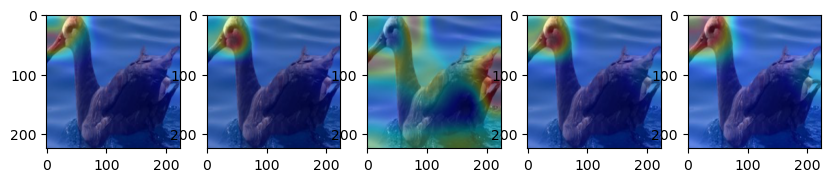

In [99]:
visualize_updated_prototype(a3c.PPnet_multi, 5163, 0)

In [28]:
def visualize_img_pattern(p_dir, pid):
    img = skio.imread('./human_comparisons/feedback_images/'+p_dir+'/original_imgs/'+pid+'.png')
    img = sk.img_as_float(img)
    pattern = np.load('./human_comparisons/feedback_images/'+p_dir+'/patterns/'+pid+'.npy')
    heatmap = cv2.applyColorMap(np.uint8(255*pattern), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]
    overlayed_original_img = 2.0 * img[:, :, :3] + 1.0 * heatmap
    overlayed_original_img = overlayed_original_img - np.amin(overlayed_original_img)
    overlayed_original_img = overlayed_original_img / np.amax(overlayed_original_img)
    plt.imshow(overlayed_original_img)

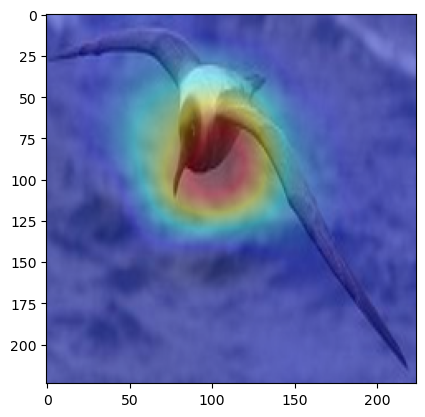

In [29]:
visualize_img_pattern('k=1_random', '89_0')

In [27]:
acc = tnt.test(model=a3c.PPnet_multi, dataloader=test_loader, class_specific=True, log=print)

	test


58it [00:17,  3.25it/s]


	time: 	18.025746822357178
	cross ent: 	2.227391403296898
	cluster: 	10.1876457600758
	separation:	35.351151499254954
	avg separation:	53.65792524403539
	accu: 		77.49395926820849%
	l1: 		1556.808349609375
	p dist pair: 	66.9355697631836
